In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision as tv
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import hamming_loss, accuracy_score

from scipy.io import arff

# Loading in data

In [183]:
scene = arff.loadarff('./scene.arff')
train = arff.loadarff('./scene-train.arff')
test = arff.loadarff('./scene-train.arff')

In [3]:
scene_df = pd.DataFrame(scene[0])
train_df = pd.DataFrame(train[0])
test_df = pd.DataFrame(test[0])

In [4]:
scene_df.shape

(2407, 300)

In [5]:
train_df.shape

(1211, 300)

In [6]:
test_df.shape

(1211, 300)

### Data label attributes:

In [184]:
data_labels = scene_df.loc[:, 'Beach': 'Urban'].astype('int').values

Cardinality

In [187]:
data_labels.sum(axis=1).mean()

1.0739509763190693

Classes are pretty uniformly distributed. So using Hamming loss should be good.

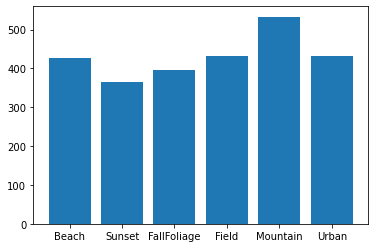

In [189]:
plt.figure()
plt.bar(range(6), data_labels.sum(axis=0))
plt.xticks(ticks=range(6), labels=scene_df.loc[:, 'Beach': 'Urban'].columns.values)
plt.show()

# Making TensorDatasets

In [134]:
X, Y = train_df.loc[:, 'Att1':'Att294'].values, train_df.loc[:, 'Beach': 'Urban'].astype('int').values
X_test, Y_test  = test_df.loc[:, 'Att1':'Att294'].values, test_df.loc[:, 'Beach': 'Urban'].astype('int').values

trans = tv.transforms.Compose([tv.transforms.Lambda(lambda x: torch.Tensor(x))])
X, Y = trans(X), trans(Y)
X_test, Y_test = trans(X_test), trans(Y_test)

train_dataset = TensorDataset(X,Y)
test_dataset = TensorDataset(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size=4)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [137]:
class SceneModel(torch.nn.Module):
    
    def __init__(self):
        super(SceneModel, self).__init__()
        self.fc1 = torch.nn.Linear(294, 100)
        self.fc2 = torch.nn.Linear(100, 6)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
num_epochs = 2000
lr = 0.1

device = torch.device('cuda')

net = SceneModel().to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)

train_loss = []
test_loss = []

for epoch in range(num_epochs+1):
    
    net.train()
    loss_tracker = 0.0
    for x, y in train_dataloader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        preds = net(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        loss_tracker+=loss.item()
    train_loss.append(loss_tracker/len(train_dataloader))
    
    net.eval()
    test_tracker = 0.0
    for x, y in test_dataloader:
        x, y = x.cuda(), y.cuda()
        preds = net(x)
        loss = criterion(preds, y)
        test_tracker += loss.item()
    test_loss.append(test_tracker/len(test_dataloader))
    
    if epoch % 25 == 0:
        print("Epoch: {}, Train loss: {}, Test loss: {}".format(epoch, train_loss[-1], test_loss[-1]))

Epoch: 0, Train loss: 0.15947365789542053, Test loss: 1.391184045286179
Epoch: 25, Train loss: 0.11067869853906075, Test loss: 1.3793956686130944
Epoch: 50, Train loss: 0.08343104705892244, Test loss: 1.144861444072466
Epoch: 75, Train loss: 0.07203334379709163, Test loss: 1.1595700793629113
Epoch: 100, Train loss: 0.057420740973491764, Test loss: 1.0579338584121365
Epoch: 125, Train loss: 0.04528668788918709, Test loss: 0.8814990247579417
Epoch: 150, Train loss: 0.040108170599580904, Test loss: 0.7805373926791854
Epoch: 175, Train loss: 0.030121477220247602, Test loss: 0.8214973243170114
Epoch: 200, Train loss: 0.02701197598217783, Test loss: 0.9727082829308183
Epoch: 225, Train loss: 0.02153230948443097, Test loss: 1.0203372609935872
Epoch: 250, Train loss: 0.017979788349074693, Test loss: 1.06458081352089
Epoch: 275, Train loss: 0.01468722359819628, Test loss: 1.0719515781462154
Epoch: 300, Train loss: 0.012341401819794526, Test loss: 1.0531185314283154
Epoch: 325, Train loss: 0.010

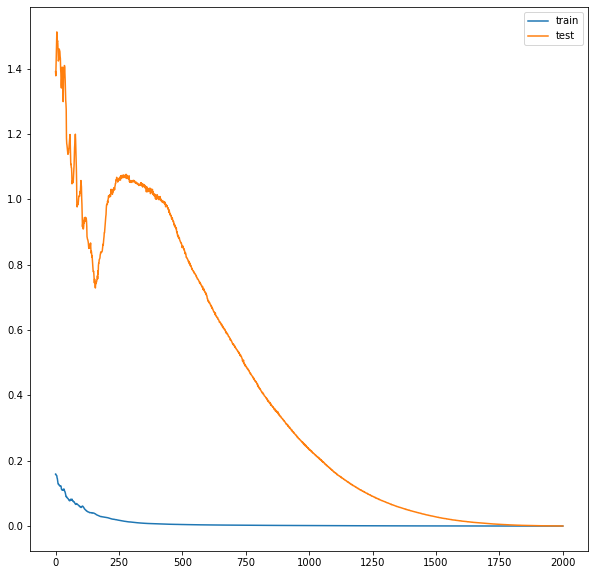

In [19]:
plt.figure(figsize=(10,10))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()

# Save the model after training.

In [25]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
def load_model(model_cls, path):
    model = model_cls(*args, **kwargs)
    model.load_state_dict(torch.load(path))
    model.eval()

In [24]:
save_model(net, './models/mod_v1.torch')

In [151]:
def eval_metrics(mod, metrics, datasets):
    res_dict = {}
    for ix, dataset in enumerate(datasets):
        mod.eval()
        x = dataset.tensors[0].cuda()
        # Make predictions.
        preds = mod(x)
        # Convert them to binary multilabels.
        y_pred = torch.round(torch.sigmoid(preds)).cpu().detach().numpy()
        y_true = dataset.tensors[1].cpu().detach().numpy()
        # Calculate metric.
        res_dict[f'dataset_{ix}'] = {metric.__name__: metric(y_true, y_pred) for metric in metrics}
    return res_dict

In [152]:
preds = net(train_dataset.tensors[0].to(device))
y_pred = torch.round(torch.sigmoid(preds)).cpu().detach().numpy()
y_true = train_dataset.tensors[1].cpu().detach().numpy()
hamming_loss(y_true, y_pred)

0.0

In [153]:
eval_metrics(net, [hamming_loss, accuracy_score], [train_dataset, test_dataset])

{'dataset_0': {'hamming_loss': 0.0, 'accuracy_score': 1.0},
 'dataset_1': {'hamming_loss': 0.0, 'accuracy_score': 1.0}}